## Evaluate Trained Robot Policy Model and Visualize

In [1]:
import os
import sys

import numpy as np
import pandas as pd

import torch

import matplotlib.pyplot as plt

from typing import List
from tqdm import tqdm

# get the current script's directory
current_directory = os.path.dirname(os.path.abspath(__file__)) if "__file__" in locals() else os.getcwd()
# get the parent directory
parent_directory = os.path.dirname(current_directory)
# add the parent directory to the sys.path
sys.path.append(parent_directory)

from utils import common, constants
from utils.config import Config
from utils.dataset_loader import PolicyDatasetLoader

from optimization.updater import Updater
from optimization.functions import setup_config, get_directories, load_policy
from optimization.functions import read_each_loader, convert_sample_2_df, trajectory_estimation

from models.policy_model import RobotPolicy

In [2]:
pd.set_option("display.max_columns",
              None)

# Initialization

In [3]:
# available evaluating machine
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Evaluating Device: ", device)

# setup hyperparameters
configs = setup_config(device=device)

# create and return preliminary base paths
json_paths, results_path = get_directories(parent_directory=parent_directory,
                                           data_folder_name=constants.TEST_COLLECTION_DATE)

Evaluating Device:  cpu
Current Time:  Feb_03_2024-20_53_56


In [4]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Evaluating Device: ", device)
configs.device = device

Evaluating Device:  cpu


In [5]:
policy_network = RobotPolicy(state_size=configs.state_size,
                             hidden_size=configs.hidden_size,
                             out_size=configs.action_size,
                             log_std_min=configs.policy_log_std_min,
                             log_std_max=configs.policy_log_std_max,
                             log_std_init=configs.policy_log_std_init,
                             device=configs.device)

In [6]:
# load test demonstrations dataset
all_test_data = PolicyDatasetLoader(demo_data_json_paths=json_paths)


================== Policy Dataset Loader ==================

Number of Trajectories:  5
Each Trajectory Length:  30
Full Demo Dataset Size:  163


In [7]:
validation_loader = torch.utils.data.DataLoader(all_test_data,
                                                batch_size=1,
                                                shuffle=False,
                                                num_workers=configs.num_workers)

# Functions

In [8]:
def plt_2D_plotting(df: pd.DataFrame,
                    column_names: List[str],
                    x_axis_name: str,
                    y_axis_name: str,
                    x_label_name: str,
                    title_label_name: str) -> None:
    
    if not isinstance(df, pd.DataFrame):
        raise TypeError("Input 'df' must be a pandas DataFrame.")
    if not isinstance(column_names, list) or not all(isinstance(name, str) for name in column_names):
        raise TypeError("Input 'column_names' must be a list of strings.")
    if not all(name in df.columns for name in column_names):
        raise ValueError("Invalid column name(s) for column_names.")
    if not all(isinstance(label, str) for label in [x_axis_name, y_axis_name, title_label_name]):
        raise TypeError("Axis labels and title must be strings.")

    for column_name in column_names:
        if column_name not in df.columns:
            raise ValueError(f"Invalid column name: {column_name}")

    if len(column_names) not in [1, 2]:
        raise ValueError("Invalid number of columns to plot. Must be 1 or 2.")

    if not isinstance(x_axis_name, str) or not isinstance(y_axis_name, str):
        raise TypeError("Axis names must be strings.")
    if not isinstance(x_label_name, str):
        raise TypeError("Column name for x axis must be string.")
    if not isinstance(title_label_name, str):
        raise TypeError("Title must be a string.")
    
    for column_name in column_names:
        plt.scatter(df[x_label_name], df[column_name],
                    label=column_name)
    
    if len(column_names) == 2:
        mae_avg = np.mean(np.abs(df[column_names[0]] - df[column_names[1]]))
        mae_max = np.max(np.abs(df[column_names[0]] - df[column_names[1]]))
        
        error_text = f"Avg. MAE = {mae_avg:.5f} m\nMax. MAE = {mae_max:.5f} m"
        
        plt.text(0.95, 0.05,
                 error_text,
                 transform=plt.gca().transAxes,
                 verticalalignment="bottom",
                 horizontalalignment="right",
                 bbox=dict(facecolor="white", alpha=0.8))
    
    plt.xlabel(x_axis_name)
    plt.ylabel(y_axis_name)
    plt.title(title_label_name)
    
    plt.legend(loc="upper right")
    
    plt.show()

# Test

In [9]:
# folder name where parameters are located ("results / policy_network_params / loading_folder_name")
loading_folder_name = "Feb_02_2024-17_39_56"

In [10]:
params_name = "policy_network_epoch_100_loss_0_57475.pt"

In [11]:
# location of the trained model parameters (make sure that the folder exists where model is trained priorly)
model_folder_path = os.path.join(results_path,
                                 "policy_network_params",
                                 loading_folder_name)

In [12]:
model_path = os.path.join(model_folder_path,
                          params_name)

In [13]:
# set trained parameters to neural network
policy_network = load_policy(policy_network=policy_network,
                             model_path=model_path)

In [14]:
# set model to evaluation mode
for param in policy_network.parameters():
    param.requires_grad = False
policy_network = policy_network.eval()

In [15]:
updater = Updater(configs=configs,
                  policy_network=policy_network)

## Test with Only One Sample from Validation Set

In [16]:
sample_index = 0

In [17]:
evaluation_sample = all_test_data[sample_index]

In [18]:
input_state, output_action, trajectory_index, state_number = read_each_loader(configs=configs,
                                                                              sample_data=evaluation_sample)

In [19]:
# add a batch dimension by unsqueezing
action_pred, action_std, action_log_prob, action_entropy, action_mu_and_std, action_dist = policy_network.estimate_action(state=input_state.unsqueeze(0),
                                                                                                                          is_inference=True)

In [20]:
# multivariate Gaussian negative log-likelihood loss function
nll_loss = updater.multivariate_gaussian_nll_loss(y_true=output_action,
                                                  y_pred=action_mu_and_std)

In [21]:
real_state_input = common.denormalize_state(state_norm=input_state.numpy(),
                                            norm_value_list=all_test_data.state_norms)

In [22]:
real_action_output = common.denormalize_action(action_norm=output_action.unsqueeze(0).numpy(),
                                               norm_range_list=all_test_data.action_norms)[0]

In [23]:
real_action_pred = common.denormalize_action(action_norm=action_pred.detach().numpy(),
                                             norm_range_list=all_test_data.action_norms)[0]

## Run Through All Samples in a Trajectory for Every Trajectory

In [24]:
# initialize an empty list to store dataframes
trajectory_dataframes = []
df = pd.DataFrame()

In [25]:
# initialize variables to keep track of the current trajectory index and dataframes
current_trajectory_index = 0

In [26]:
for sample_data in tqdm(validation_loader):
    
    input_state, output_action, trajectory_index, state_number = read_each_loader(configs=configs,
                                                                                  sample_data=tuple(sample_data))
    action_pred, action_std, action_log_prob, action_entropy, action_mu_and_std, action_dist = policy_network.estimate_action(state=input_state,
                                                                                                                              is_inference=True)
    nll_loss = updater.multivariate_gaussian_nll_loss(y_true=output_action,
                                                      y_pred=action_mu_and_std)
    
    real_state_input = common.denormalize_state(state_norm=input_state.numpy(),
                                                norm_value_list=all_test_data.state_norms)
    real_action_output = common.denormalize_action(action_norm=output_action.numpy(),
                                                   norm_range_list=all_test_data.action_norms)
    real_action_pred = common.denormalize_action(action_norm=action_pred.detach().numpy(),
                                                 norm_range_list=all_test_data.action_norms)
    
    # validaton dataset sampling is done with size of one
    trajectory_index = int(trajectory_index[0].item())
    state_number = int(state_number[0].item())
    
    # store every important detail in the dataframe (only take zero index values, because validation dataset batch size is taken as 1)
    sample_df = convert_sample_2_df(input_state=input_state.squeeze(0),
                                    real_state_input=real_state_input[0],
                                    output_action=output_action.squeeze(0),
                                    real_action_output=real_action_output[0],
                                    action_log_prob=action_log_prob.squeeze(0),
                                    action_pred=action_pred.squeeze(0),
                                    action_std=action_std.squeeze(0),
                                    real_action_pred=real_action_pred[0],
                                    trajectory_index=trajectory_index,
                                    state_number=state_number,
                                    nll_loss=nll_loss.item())
    
    # check if the trajectory index has changed
    if trajectory_index == current_trajectory_index:
        
        if len(df) != 0:
            df = pd.concat([df, sample_df],
                           ignore_index=True)
        else:
            df = sample_df.copy(deep=True)
    
    else:
        # append the dataframe to the list
        trajectory_dataframes.append(df)
        
        # create a new dataframe for each trajectory_index
        df = sample_df.copy(deep=True)
        
        # update the current_trajectory_index
        current_trajectory_index = trajectory_index

if len(trajectory_dataframes) == 0:
    trajectory_dataframes.append(df)

100%|███████████████████████████████████████████████████████████████████████████████| 163/163 [00:00<00:00, 319.62it/s]


In [27]:
action_1_columns = [constants.ACTION_PREDICTION_DENORMALIZED_NAME + "_1",
                    constants.ACTION_DENORMALIZED_LABEL_NAME + "_1"]
action_1_title_name = "Prediction vs. Actual End-Effector X-Axis Position"
action_1_y_axis_name = "X-Axis Location [m]"

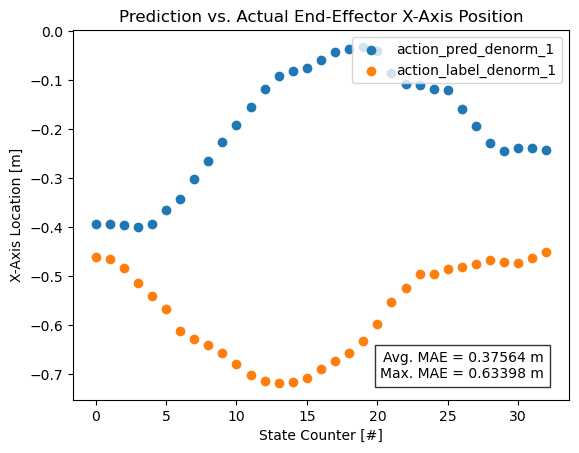

In [28]:
plt_2D_plotting(df=trajectory_dataframes[-1],
                column_names=action_1_columns,
                x_axis_name="State Counter [#]",
                y_axis_name=action_1_y_axis_name,
                x_label_name=constants.STATE_NUMBER_COLUMN,
                title_label_name=action_1_title_name)

## Get Estimated Next States while Applying Trained Policy Model Action

In [29]:
# index location where the each trajectory starts in the dataframe
traj_start_index = 0

trajectory_df = trajectory_estimation(configs=configs,
                                      data_loader=all_test_data,
                                      policy_network=policy_network,
                                      trajectory_length=constants.TRAJECTORY_SIZE,
                                      traj_start_index=traj_start_index,
                                      is_inference=True)


state_number :  0
current_state_denorm_label :  [0.79646313 1.45202374 0.         0.81869459]
next_state_denorm_label :  [0.79646097 1.45199453 0.         0.81868392]

state_number :  1
current_state_denorm_label :  [7.96460986e-01 1.45199454e+00 3.30548646e-05 8.18683922e-01]
next_state_denorm_label :  [0.79886508 1.45011302 0.0100528  0.82451397]

state_number :  2
current_state_denorm_label :  [0.79886508 1.45011306 0.01007153 0.82451397]
next_state_denorm_label :  [0.82340533 1.43871466 0.06195645 0.84462433]

state_number :  3
current_state_denorm_label :  [0.82340533 1.43871462 0.06197781 0.84462428]
next_state_denorm_label :  [0.8621511  1.40451542 0.15691174 0.8700419 ]

state_number :  4
current_state_denorm_label :  [0.86215109 1.40451539 0.15693602 0.87004191]
next_state_denorm_label :  [0.89525412 1.38226718 0.22406833 0.88505345]

state_number :  5
current_state_denorm_label :  [0.89525414 1.38226724 0.22409332 0.8850534 ]
next_state_denorm_label :  [0.92655411 1.37257741

In [30]:
trajectory_df

,state_label_norm_1,state_label_norm_2,state_label_norm_3,state_label_norm_4,state_label_denorm_1,state_label_denorm_2,state_label_denorm_3,state_label_denorm_4,action_label_norm_1,action_label_norm_2,action_label_norm_3,action_label_denorm_1,action_label_denorm_2,action_label_denorm_3,action_pred_logprob_1,action_pred_logprob_2,action_pred_logprob_3,action_pred_norm_1,action_pred_norm_2,action_pred_norm_3,action_pred_std_1,action_pred_std_2,action_pred_std_3,action_pred_denorm_1,action_pred_denorm_2,action_pred_denorm_3,trajectory_index,state_number,gnll_loss,next_state_label_norm_1,next_state_label_norm_2,next_state_label_norm_3,next_state_label_norm_4,next_state_label_denorm_1,next_state_label_denorm_2,next_state_label_denorm_3,next_state_label_denorm_4,state_est_norm_1,state_est_norm_2,state_est_norm_3,state_est_norm_4,state_est_denorm_1,state_est_denorm_2,state_est_denorm_3,state_est_denorm_4
0,0.398231565952,0.726011872292,0.000000000000,0.409347295761,0.796463131905,1.452023744583,0.000000000000,0.818694591522,-0.133177444339,-0.212761536241,0.325091958046,-0.266354918480,-0.425523042679,0.650183916092,0.740534067154,0.741080284119,0.740630507469,-0.250143945217,-0.188753411174,0.333444029093,0.190239295363,0.190135404468,0.190220937133,-0.500287890434,-0.377506852150,0.666887998581,0,0,0.000000000000,0.398230486951,0.725997262622,0.000000000000,0.409341958046,0.796460973901,1.451994525243,0.000000000000,0.818683916092,0.491368855674,0.713148963420,0.119696717052,0.417693999290,0.982737711348,1.426297926840,0.239393434104,0.835387998581
1,0.398230493069,0.725997269154,0.000016527432,0.409341961145,0.796460986137,1.451994538307,0.000033054865,0.818683922291,-0.136032298207,-0.209825992584,0.328006982803,-0.272064566612,-0.419651985168,0.656013965607,0.740534067154,0.741080284119,0.740630507469,-0.193280249834,-0.156217187643,0.335532486439,0.190239295363,0.190135404468,0.190220937133,-0.386560440063,-0.312434434891,0.671064853668,0,1,0.000000000000,0.399432541091,0.725056509132,0.005026402178,0.412256982803,0.798865082182,1.450113018265,0.010052804356,0.824513965607,0.427199245652,0.685061841429,0.083178143440,0.419782426834,0.854398491304,1.370123682858,0.166356286881,0.839564853668
2,0.399432539940,0.725056529045,0.005035765469,0.412256985903,0.798865079880,1.450113058090,0.010071530938,0.824513971806,-0.156389713287,-0.196867644787,0.338062137365,-0.312779426575,-0.393735289574,0.676124334335,0.740534067154,0.741080284119,0.740630507469,-0.198827147484,-0.122481502593,0.337824702263,0.190239295363,0.190135404468,0.190220937133,-0.397654294968,-0.244963049889,0.675649404526,0,2,0.000000000000,0.411702666448,0.719357330001,0.030978224198,0.422312167168,0.823405332895,1.438714660002,0.061956448397,0.844624334335,0.421621230405,0.660332502556,0.112349820164,0.422074702263,0.843242460810,1.320665005113,0.224699640328,0.844149404526
3,0.411702662706,0.719357311726,0.030988903716,0.422312140465,0.823405325413,1.438714623451,0.061977807432,0.844624280930,-0.190853595734,-0.166184976697,0.350770950317,-0.381707191467,-0.332369923592,0.701541900635,0.740534067154,0.741080284119,0.740630507469,-0.179404541850,-0.087965741754,0.336874216795,0.190239295363,0.190135404468,0.190220937133,-0.358809113503,-0.175931453705,0.673748493195,0,3,0.000000000000,0.431075547829,0.702257709011,0.078455868256,0.435020950317,0.862151095657,1.404515418022,0.156911736512,0.870041900635,0.394044048540,0.633279215198,0.133602983460,0.421124246597,0.788088097080,1.266558430396,0.267205966920,0.842248493195
4,0.431075543165,0.702257692814,0.078468009830,0.435020953417,0.862151086330,1.404515385628,0.156936019659,0.870041906834,-0.215731024742,-0.144678264856,0.358276695013,-0.431462049484,-0.289356470108,0.716553449631,0.740534067154,0.741080284119,0.740630507469,-0.177644774318,-0.050959076732,0.333465903997,0.190239295363,0.190135404468,0.190220937133,-0.355289578438,-0.101918101311,0.666931867599,0,4,0.000000000000,0.447627057525,0.691133591279,0.11